#### **Summarization**

Text summarization can broadly be divided into two categories — Extractive Summarization and Abstractive Summarization.

**Extractive Summarization**: These methods rely on extracting several parts, such as phrases and sentences, from a piece of text and stack them together to create a summary. Therefore, identifying the right sentences for summarization is of utmost importance in an extractive method.

**Abstractive Summarization**: These methods use advanced NLP techniques to generate an entirely new summary. Some parts of this summary may not even appear in the original text.

In this notebook we will be using Extractive Summarization



#### Mounting Google Drive to load the data

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


#### Data paths in drive

In [4]:
!ls '/content/gdrive/My Drive/Colab Notebooks/datasets/'
!gunzip '/content/gdrive/My Drive/Colab Notebooks/datasets/signalmedia-1m.jsonl.gz'

signalmedia-1m.jsonl.gz


#### Importing relevant packages

In [17]:
import json
import pandas as pd
import spacy
from collections import Counter
nlp=spacy.load('en')

#### data paths

In [ ]:
data_path='/content/gdrive/My Drive/Colab Notebooks/datasets/signalmedia-1m.jsonl'
car_manufacturers_url='https://gist.githubusercontent.com/pcgeek86/78f4cad29dd16961ceeeee654127a0db/raw/b9a19ee5c6fb283eaf2f863a18ba9176359abd47/Car%2520Manufacturers.json'


#### data load

In [ ]:
with open(data_path, 'r') as json_file:
    json_list = list(json_file)


#### Filtering emission related articles

In [22]:
def pickEmissionArticles(articles):
  emission_indices=[]
  for i,a in enumerate(articles):
    a=eval(a)
    if 'emission' in a['content'].lower() or 'emission' in a['title'].lower():
      emission_indices.append(i)
  return emission_indices

emission_index=pickEmissionArticles(json_list)

#### Getting emission related indices

In [24]:
emission_json_list=[json_list[i] for i in emission_index]
len(emission_json_list)

10622

#### Converting string values to list of dictionaries

In [26]:
emission_json_list=[eval(x) for x in emission_json_list]
emission_json_list[0]

{'content': 'The fuel economy and smog ratings are shown on the sticker price of a 2015 Passat limited edition vehicle at a Volkswagen dealership in Escondido, California, September 21, 2015. —\xa0Reuters pic FRANKFURT, Sept 22 — German auto giant Volkswagen’s shares plummeted nearly 20 per cent yesterday as investigations spread into revelations\xa0that hundreds of thousands of its diesel cars have software that secretly thwarts US pollution tests. \n \nVolkswagen, the world’s largest automaker by sales in the first half of this year, said it had halted all diesel vehicle sales in the United States during a probe into the scandal, which could lead to fines of more than US$18 billion (RM76.786 billion). \n \nIn addition to the environmental fines, US authorities have reportedly launched a criminal investigation into the company. \n \nAccording to the US authorities, VW admitted that it had equipped about 482,000 cars in the US with\xa0sophisticated software that covertly turns off poll

#### Creating pandas data frame 

In [28]:
emission_df=pd.DataFrame(emission_json_list)
emission_df.head()

,id,content,title,media-type,source,published
0,d86e447d-da83-4cc3-80b1-6dc3b561ee8f,The fuel economy and smog ratings are shown on...,Criminal probe: Volkswagen slams into huge fal...,News,Malay Mail,2015-09-22T00:38:00Z
1,1746cde7-2075-4809-8982-fa3b4c26d551,The German automakers really know how to make ...,Mercedes Benz debuts sleek new C-Class Coupe -...,Blog,uautoknow.net,2015-08-31T23:23:44Z
2,397fa71a-31b1-4216-8b90-c605a97f6d52,:14 \n\nIn late morning trade on the Frankfurt...,Volkswagen shares slide more than 6% in late m...,News,North Eastern Tribune,2015-09-28T10:11:52Z
3,a3a59992-1635-433a-8a8e-f853d2182055,I’m in the Arctic with JacksGap and glaciologi...,To the Arctic with JacksGap,Blog,WWF UK Blog,2015-09-28T14:36:20Z
4,4f802018-0e59-4e94-a45f-bd2858d71049,European stock markets recovered their poise T...,US stocks are stable in early trade; energy se...,News,Wichita Eagle,2015-09-29T13:48:07Z


#### Loading all car manufactures

In [41]:
all_car_manufactures=pd.read_json(car_manufacturers_url)
all_car_manufactures.columns=['company_name']
all_car_manufactures['company_name']=all_car_manufactures['company_name'].apply(str.lower)
all_car_manufactures.head()

,company_name
0,abarth
1,alfa romeo
2,aston martin
3,audi
4,bentley


#### Function to return the main subject of the article

1. Use spacy to find the ORG entity
2. Check whether that entity is present in manufacturer list
3. Create a Counter object of all the entities found in step 2
4. Return the most common entity name from the article

In [50]:
def getMainAutomobileSubject(article):
  org_list=[]
  subject=''
  doc=nlp(article)
  for d in doc.ents:
    if d.label_=='ORG' and d.text.lower() in all_car_manufactures['company_name'].tolist():
      org_list.append(d.text)
  if org_list:
    counter_obj=Counter(org_list)
    subject=counter_obj.most_common(1)[0][0]
  return subject
getMainAutomobileSubject(emission_df['content'][0])

'Volkswagen'

This method takes little bit of time to run , hence its a good idea to save this in gdrive , so that we dont have to repeat this process again

In [53]:
emission_df['subject_company']=emission_df.apply(lambda x:
                                                     getMainAutomobileSubject(
                                                     x['title'].lower()+" "+x['content'].lower()),
                                                     axis=1)
emission_df.head()

,id,content,title,media-type,source,published,subject_company
0,d86e447d-da83-4cc3-80b1-6dc3b561ee8f,The fuel economy and smog ratings are shown on...,Criminal probe: Volkswagen slams into huge fal...,News,Malay Mail,2015-09-22T00:38:00Z,volkswagen
1,1746cde7-2075-4809-8982-fa3b4c26d551,The German automakers really know how to make ...,Mercedes Benz debuts sleek new C-Class Coupe -...,Blog,uautoknow.net,2015-08-31T23:23:44Z,mercedes-benz
2,397fa71a-31b1-4216-8b90-c605a97f6d52,:14 \n\nIn late morning trade on the Frankfurt...,Volkswagen shares slide more than 6% in late m...,News,North Eastern Tribune,2015-09-28T10:11:52Z,volkswagen
3,a3a59992-1635-433a-8a8e-f853d2182055,I’m in the Arctic with JacksGap and glaciologi...,To the Arctic with JacksGap,Blog,WWF UK Blog,2015-09-28T14:36:20Z,
4,4f802018-0e59-4e94-a45f-bd2858d71049,European stock markets recovered their poise T...,US stocks are stable in early trade; energy se...,News,Wichita Eagle,2015-09-29T13:48:07Z,volkswagen


#### Saving the file in gdrive

In [54]:
emission_df.to_csv("/content/gdrive/My Drive/Colab Notebooks/datasets/emission_df.csv")

In [1]:
import pandas as pd
emission_df=pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/datasets/emission_df.csv")

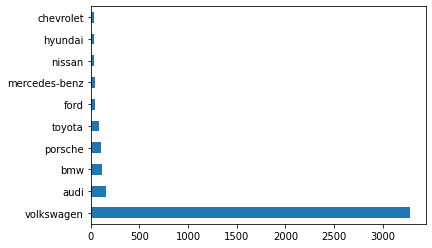

In [2]:
emission_df['subject_company'].value_counts()[:10].plot(kind='barh')

In [3]:
emission_df=emission_df.dropna(subset=['subject_company'])
emission_df.shape

(4168, 8)

Insight: Volkswagen is quite famous for being in the news !

In [4]:
emission_df.shape

(4168, 8)

In [5]:
top_companies=emission_df['subject_company'].value_counts()[:10].index
print(top_companies)
emission_df=emission_df[emission_df['subject_company'].isin(top_companies)]
emission_df.shape

Index(['volkswagen', 'audi', 'bmw', 'porsche', 'toyota', 'ford',
       'mercedes-benz', 'nissan', 'hyundai', 'chevrolet'],
      dtype='object')


(3926, 8)

#### Group by Subject Companies gather all the text in a dataframe


In [6]:
grouped=emission_df.groupby(['subject_company'])

#### Creating a company and overall text pandas dataframe

In [7]:
company_text=pd.DataFrame(grouped.apply(lambda x : '. '.join('. '.join([t[0],t[1]])
               for t in list(zip(x.title.tolist(),x.content.tolist())))))
company_text.columns=['text']
company_text=company_text.reset_index()
company_text.head()

,subject_company,text
0,audi,"Audi welcome in F1 says Wolff. SEPTEMBER 25, 2..."
1,bmw,Inside the brain of sustainability reporting. ...
2,chevrolet,Cars We Remember: 1974 Chevy Laguna Type S-3. ...
3,ford,Driven Alfa Romeo Giulietta Business Edition. ...
4,hyundai,Keyes Hyundai In Los Angeles Added To Growing ...


#### Text Rank Algorithm Implementation

TextRank is an extractive and unsupervised text summarization technique. Let’s take a look at the flow of the TextRank algorithm that we will be following:

![alt text](https://github.com/imtiazBDSgit/interview/blob/master/TextRank.JPG?raw=true)


  1.The first step would be to concatenate all the text contained in the articles

  2.Then split the text into individual sentences

  3.In the next step, we will find vector 
  representation (word embeddings) for each and every sentence

  4.Similarities between sentence vectors are then calculated and stored in a matrix

  5.The similarity matrix is then converted into a graph, with sentences as vertices and similarity scores as edges, for sentence rank calculation

  6.Finally, a certain number of top-ranked sentences form the final summary


**In order to perform above steps we will use gensim text rank algorithm.**



In [10]:
from gensim.summarization.summarizer import summarize 
from gensim.summarization import keywords 

#### Function to return summary so it can be directly applied to dataframe object


In [11]:
def summarize_text(text,word_count=200):
  summ_per = summarize(text, word_count = 200) 
  return summ_per
  


In [27]:
%%time
summarize_text(company_text.iloc[1]['text'])

CPU times: user 270 ms, sys: 8.01 ms, total: 278 ms
Wall time: 274 ms


"In true Bentley fashion, the Bentayga combines unparalleled luxury and effortless performance while still being true to being a bespoke vehicle designed, engineered, and built in Crewe, UK.\nDriving the Bentayga is made easier with a full suite of technologies including Adaptive Cruise Control with a setting for stop and go traffic, Predictive ACC and Traffic Assist that enables the driver to set a predetermined distance to vehicle in front.\nNew Bentley 4x4 costs £160,000 and is aimed at top-end of 4x4 market Bentley hopes it will become one of its biggest sellers Blistering performance sees Bentayga hit 62mph in 4.1 seconds Car has hands-free tailgate and optional hamper that turns into seats  \nRiding high: Bentley's new Bentayga claims to be the most powerful and luxurious 4x4 on sale \nBentley Motors chairman and chief executive Wolfgang Duerheimer said: ’The Bentayga redefines luxury in the sports utility vehicle sector and offers a genuine Bentley experience in any environment,

In [17]:
%%time
company_text=company_text[company_text.subject_company!='volkswagen']
company_text['summary']=company_text['text'].apply(summarize_text)
company_text.to_csv("/content/gdrive/My Drive/Colab Notebooks/datasets/out_summarization.csv")
company_text

CPU times: user 4min 6s, sys: 6.77 s, total: 4min 13s
Wall time: 4min 12s


###### References

https://www.analyticsvidhya.com/blog/2018/11/introduction-text-summarization-textrank-python/